In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import tensorflow as tf

In [2]:
# Import train and test data sets
sales_train = pd.read_csv('../Data/sales_train_merge.csv', index_col = 0, parse_dates=['date'])
sales_test = pd.read_csv('../Data/sales_test_merge.csv', index_col = 0, parse_dates=['date'])

C:\Users\Curtis\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,profits,item_category_id
0,2013-01-31,0,0,32,884.0,6.0,1326.0,40
1,2013-01-31,0,0,33,1041.0,3.0,1041.0,37
2,2013-01-31,0,0,35,247.0,1.0,247.0,40
3,2013-01-31,0,0,43,221.0,1.0,221.0,40
4,2013-01-31,0,0,51,257.0,2.0,257.0,57


In [4]:
sales_test.head()

,ID,shop_id,item_id,item_category_id,date,date_block_num
0,0,5,5037,19,2015-11-30,34
1,1,5,5320,55,2015-11-30,34
2,2,5,5233,19,2015-11-30,34
3,3,5,5232,23,2015-11-30,34
4,4,5,5268,20,2015-11-30,34


# Preprocessing

Before a machine learning algorithm can be developed to fit the data, the data needs to be formatted and preprocessed to remove redundancies, standardize the data, or add extra columns. In this instance, columns like ``item_price``, ``profits``, and ``item_category_id`` could be removed. The ``item_category_id`` column could be removed since each item belongs to a specific column and therefore is correlated to ``item_id``. If kept, the model could deceivingly perform better than implied. The other two columns, ``item_price`` and ``profits``, could be removed since the ``item_price`` could depend on the date due to depreciation or inflation and ``profits`` dependent on ``item_price``.

In [5]:
# Remove unnecessary columns from sales_train
sales_train.drop(['item_price', 'profits', 'item_category_id'], axis=1, inplace=True)

Now that those columns have been removed, the next issue to handle are the ``date`` and ``date_block_num`` columns. As with the ``profits`` and ``item_category_id`` columns, these two columns are correlated to each other and redundant. It'll suit the problem better if the ``date_block_num`` column was removed and the ``date`` column split into two new ones, ``month`` and ``year``.

In [6]:
# Remove date_block_num from training data
sales_train.drop(['date'], axis=1, inplace=True)

Now that the training set has been preprocessed, the same needs to be done to the test set.

In [7]:
# Preprocess test set
sales_test.drop(['item_category_id', 'date'], axis=1, inplace=True)

In [8]:
sales_train.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [9]:
sales_test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


Finally, before modeling, outliers need to be removed from the *sales_train* data and then split into a training and validation set. With the data split into predictor and target variables for both the training and validation sets, the predictor variables will be scaled for 

In [10]:
sales_train = sales_train[(sales_train['item_cnt_day'] <= 30) & (sales_train['item_cnt_day'] >= 0)]

In [11]:
# Split the data into training and hold out sets
train = sales_train[sales_train['date_block_num'] < 33]

val = sales_train[sales_train['date_block_num'] == 33]

In [12]:
# Separate dependent variable from data
X_train = train.drop('item_cnt_day', axis = 1)
y_train = train['item_cnt_day']

X_val = val.drop('item_cnt_day', axis=1)
y_val = val['item_cnt_day']

In [13]:
# Standardize and scale data
scaler = StandardScaler()

# Fit and transform sales_train data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation data
X_val_scaled = scaler.transform(X_val)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [14]:
# Transform sales_test according to scaler
X_test_scaled = scaler.transform(sales_test.drop('ID', axis=1))

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


# Custom Functions

In [15]:
def model_score(model, train_data, val_data):
    '''This function prints out the scores (R^2) of training and validation sets'''
    train_score = model.score(train_data, y_train)
    val_score = model.score(val_data, y_val)
    
    print('Train score: %.3f' % train_score)
    print('Validation score: %.3f' % val_score)

In [16]:
def model_rmse(model, train_data, val_data):
    '''This function calculates the RMSE of the training and validation sets. Returns the predictions of each set'''
    train_predictions = np.round(model.predict(train_data))
    val_predictions = np.round(model.predict(val_data))
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    
    print('Train RMSE: %.3f' % train_rmse)
    print('Validation RMSE: %.3f' % val_rmse)
    
    return train_predictions, val_predictions

In [17]:
def plot_resid(validation_pred):
    '''This function plots residual distribution of the validation set'''
    resid_df = pd.DataFrame(y_val)
    resid_df['predicted'] = validation_pred
    resid_df['residual'] = resid_df['item_cnt_day'] - resid_df['predicted']
    
    print(resid_df['residual'].describe())

    _ = plt.figure(figsize=(10,10))
    _ = plt.hist(resid_df.residual)
    _ = plt.title('Residual Distribution')
    _ = plt.xlabel('Residual')
    _ = plt.ylabel('Count')

# Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
# Create grid search parameters to search over

# Number of trees
rfr_n_estimators = [int(x) for x in np.linspace(50, 150, 11)]

# Max depth of trees
rfr_max_depth = [int(x) for x in np.linspace(5, 20, 4)]

# Minimum number of samples required to split
rfr_min_samples_split = [2, 5]

# Create the grid search
rfr_params = {'n_estimators':rfr_n_estimators,
              'max_depth':rfr_max_depth,
              'min_samples_split':rfr_min_samples_split}

In [20]:
# Instantiate RandomForestRegressor model
rfr = RandomForestRegressor()

rfr_grid = GridSearchCV(estimator = rfr,
                        param_grid = rfr_params,
                        n_jobs = 4,
                        verbose = 1)

rfr_grid.fit(X_train_scaled, y_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 88 candidates, totalling 264 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 91.8min
[Parallel(n_jobs=4)]: Done 264 out of 264 | elapsed: 149.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
rfr_grid.best_params_

{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 130}

In [22]:
rfr_best = rfr_grid.best_estimator_

In [23]:
model_score(rfr_best, X_train_scaled, X_val_scaled)

Train score: 0.318
Validation score: 0.116


In [24]:
rfr_train_pred, rfr_val_pred = model_rmse(rfr_best, X_train_scaled, X_val_scaled)

Train RMSE: 2.059
Validation RMSE: 2.303


count    31393.000000
mean         0.038639
std          2.302647
min        -18.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         29.000000
Name: residual, dtype: float64


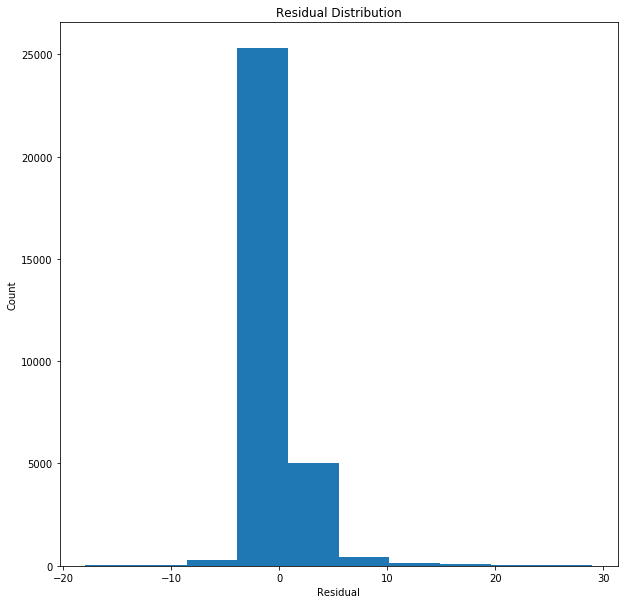

In [25]:
plot_resid(rfr_val_pred)

In [26]:
# Save RFR model
pickle.dump(rfr_best, open('rfr_model.sav', 'wb'))

# rfr_best = pickle.load(open('rfr_model.sav', 'rb'))

In [27]:
# Get important features
rfr_importance = pd.DataFrame(rfr_best.feature_importances_,
                              index = X_train.columns,
                              columns = ['importance'])
rfr_importance.sort_values('importance', ascending=False)

,importance
item_id,0.649119
date_block_num,0.185561
shop_id,0.165321


By fitting a rough random forest regressor model to the training data, the model produces decent results with roughly normalized residuals. One take away is that the model found that the ``item_id`` was most important in determining ``item_cnt_day`` for the month. That makes sense as it's largely the item being sold that determines how many copies are bought. However, when and who sells the item could arguably be an equally, or close to, contributing factor.

# Gradient Boosting Regressor

In [28]:
from xgboost import XGBRegressor

In [29]:
# Create grid search parameters to randomize over

# Learning rate
xgb_learning_rate = [0.1, 0.01]

# Number of trees
xgb_n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 11)]

# Max depth of trees
xgb_max_depth = [5, 10, 15]

# Minimum number of samples required to split
xgb_min_samples_split = [2, 5]

# Create the random grid search
xgb_params = {'learning_rate':xgb_learning_rate,
              'n_estimators':xgb_n_estimators,
              'max_depth':xgb_max_depth,
              'min_samples_split':xgb_min_samples_split}

In [30]:
# Instatiate GradientBoostingRegressor model
xgb_regressor = XGBRegressor()

# Instatiate RandomSearchCV
xgb_grid = GridSearchCV(estimator = xgb_regressor,
                        param_grid = xgb_params,
                        n_jobs = 4,
                        verbose = 1)

xgb_grid.fit(X_train_scaled, y_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 132 candidates, totalling 396 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 72.1min
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed: 152.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'learning_rate': [0.1, 0.01], 'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
xgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [32]:
xgb_best = xgb_grid.best_estimator_

In [33]:
model_score(xgb_best, X_train_scaled, X_val_scaled)

Train score: 0.534
Validation score: 0.186


In [34]:
xgb_train_pred, xgb_val_pred = model_rmse(xgb_best, X_train_scaled, X_val_scaled)

Train RMSE: 1.710
Validation RMSE: 2.219


count    31393.000000
mean         0.037015
std          2.218828
min        -18.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         29.000000
Name: residual, dtype: float64


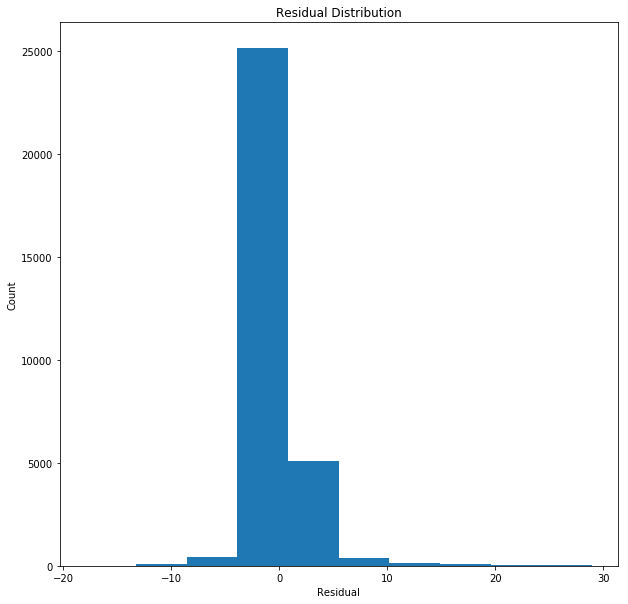

In [35]:
plot_resid(xgb_val_pred)

In [36]:
# Save XGB model
pickle.dump(xgb_best, open('xgb.pickle.dat', 'wb'))

# xgb_best = pickle.load(open('xgb.pickle.dat', 'rb'))

In [37]:
# Get important features
xgb_importance = pd.DataFrame(xgb_best.feature_importances_,
                              index = X_train.columns,
                              columns = ['importance'])
xgb_importance.sort_values('importance', ascending=False)

,importance
item_id,0.378688
shop_id,0.326847
date_block_num,0.294465


As with the random forest regressor model, a XGBoost regressor model performs decently on the validation set. An argument could be made that it's able to capture more underlying patterns in the data with a lower RMSE score, but it's miniscule. Unlike the random forest model though, is that it sees all predictor variables almost equally important to each other which is what might be expected when initially looking at this problem.

# Neural Network

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [39]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=5)

In [40]:
# model_checkpoint_dir = os.path.dirname('nn_model.hdf5')
nn_cp_callback = tf.keras.callbacks.ModelCheckpoint('nn_model.hdf5',
                                                   save_best_only = True,
                                                   verbose = 1)

In [41]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])

In [54]:
model = Sequential()
model.add(LSTM(15, return_sequences=False, input_shape=(1, 3)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [55]:
model.fit(X_train_reshaped, y_train,
         validation_data = (X_val_reshaped, y_val),
         epochs = 100,
         callbacks = [early_stopping_monitor, nn_cp_callback])

Train on 1570649 samples, validate on 31393 samples
Epoch 1/100
1570649/1570649 [==============================] - 55s 35us/step - loss: 6.0048 - val_loss: 5.9319

Epoch 00001: val_loss did not improve from 5.89069
Epoch 2/100
1570649/1570649 [==============================] - 54s 34us/step - loss: 5.9692 - val_loss: 5.9130

Epoch 00002: val_loss did not improve from 5.89069
Epoch 3/100
1570649/1570649 [==============================] - 54s 35us/step - loss: 5.9633 - val_loss: 5.9164

Epoch 00003: val_loss did not improve from 5.89069
Epoch 4/100
1570649/1570649 [==============================] - 54s 35us/step - loss: 5.9584 - val_loss: 5.9402

Epoch 00004: val_loss did not improve from 5.89069
Epoch 5/100
1570649/1570649 [==============================] - 54s 35us/step - loss: 5.9529 - val_loss: 5.9183

Epoch 00005: val_loss did not improve from 5.89069
Epoch 6/100
1570649/1570649 [==============================] - 54s 35us/step - loss: 5.9432 - val_loss: 5.9278

Epoch 00006: val_loss

In [56]:
rnn_train_pred, rnn_val_pred = model_rmse(model, X_train_reshaped, X_val_reshaped)

Train RMSE: 2.449
Validation RMSE: 2.453


count    31393.000000
mean         0.121078
std          2.449872
min         -3.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         29.000000
Name: residual, dtype: float64


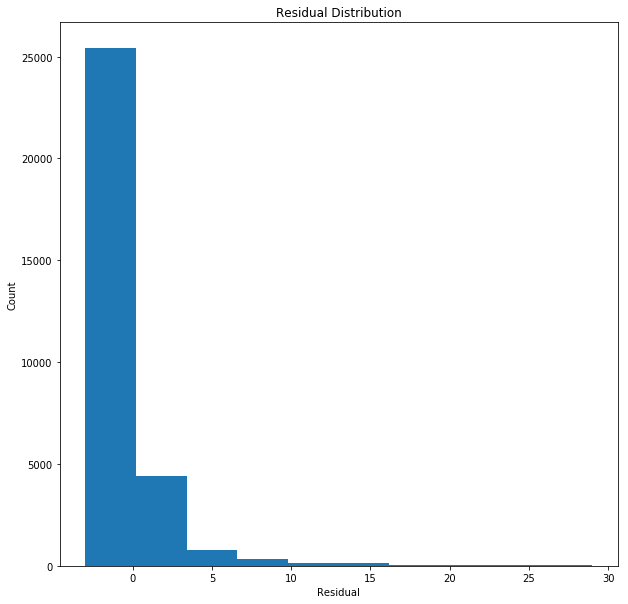

In [57]:
plot_resid(rnn_val_pred)

In [46]:
# Load best NN model
# model_best = keras.models.load_model('nn_model.hdf5')

Building a simple neural network did not seem to improve upon the results of the XGBoost regression model as the resulting validation RMSE for the neural network is slightly greater than that of the XGBoost. Further tweaks to either the model architecture and/or the data could be necessary but otherwise it also performed decently.

# Test Data

In [69]:
# Create empty dataframe for test predictions
test_pred = pd.DataFrame(sales_test)

In [70]:
# Make test predictions with RFR
rfr_test_pred = rfr_best.predict(X_test_scaled)

In [71]:
# Make test predictions with XGB
xgb_test_pred = xgb_best.predict(X_test_scaled)

In [72]:
# Make test predictions with NN
# Reshape test set
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

nn_test_pred = model.predict(X_test_reshaped)

In [73]:
# Append model predictions to test_pred data frame
test_pred['rfr_pred'] = rfr_test_pred
test_pred['xgb_pred'] = xgb_test_pred
test_pred['nn_pred'] = nn_test_pred

In [74]:
test_pred.head(10)

,ID,shop_id,item_id,date_block_num,rfr_pred,xgb_pred,nn_pred
0,0,5,5037,34,1.273781,1.211479,1.101081
1,1,5,5320,34,1.273781,1.211479,1.080750
2,2,5,5233,34,1.273781,1.211479,1.080750
3,3,5,5232,34,1.273781,1.211479,1.080750
4,4,5,5268,34,1.273781,1.211479,1.080750
5,5,5,5039,34,1.273781,1.211479,1.100234
6,6,5,5041,34,1.273781,1.211479,1.099385
7,7,5,5046,34,1.273781,1.211479,1.097267
8,8,5,5319,34,1.273781,1.211479,1.080750
9,9,5,5003,34,1.273781,1.211479,1.115524


Although it could be argued that the XGBoost regressor model overfit the training data, based on how well it performed on the validation set, it'll be the model of choice to use to predict the test set. Ensembling all the models was contemplated but seeing as of of them performed similarly on the validation set, it didn't provide much of a benefit.

In [75]:
# Read sample submission
sample_sub = pd.read_csv('../all/sample_submission.csv.gz', compression = 'gzip')
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [76]:
# Round all values of xgb_pred to nearest integer
test_pred['item_cnt_month'] = np.round(xgb_test_pred)

In [77]:
xgb_test_sub = test_pred[['ID', 'item_cnt_month']]
xgb_test_sub.head()

,ID,item_cnt_month
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [79]:
xgb_test_sub.to_csv('../Submissions/xgb_test_submission.csv', index=False)

# Conclusion and Future Work

Given the data on how many items were sold and who sold them when for 33 months, the task was to develop predictions on how many items will sell in which shops for the following month. A brief analysis was done and found the items tend to sell more as it gets closer to the end of the year and Christmas time. It was also found the items are typically bought items aren't typically bought in bulk or copies don't tend to sell more than a few copies in a month.

Nevertheless, a few basic models were constructed and all performed relatively well on a validation set resulting in RMSEs of around $2.3$. There are a couple caveats however from these results. The first is that little feature engineering was done on the given data. Further analysis could incorporate data on how similar items sold in past years. Another point should be made on how the models were constructed. Each of the models were preliminary and weren't optimized further on the data and could have possibly overfit the data. Future iterations of this project should look into each of the models performance.